# Plotting CTD Data

REMEMBER!!! you only have to run the below cell ONCE

In [1]:
# import sys
# !conda install --yes --prefix {sys.prefix} pandas
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --channel conda-forge --yes --prefix {sys.prefix} gsw


In [2]:
import pandas as pd
import numpy as np
import gsw
import matplotlib.pyplot as plt

In [3]:
# Load in a subset so we can calculate salinity,density,depth ourselves.
data = pd.read_csv('./2021_02_08_ru34_Deployment_Orsted.cnv',
                   skiprows=np.arange(0,123), # Lets us skip the big header at the top of the file
                   names=['Temperature [°C]', # gives names to each of the columns 
                          'Conductivity [S/m]',
                          'Pressure [db]'],
                   index_col=False,           # Forces pandas to not take the first column as an index
                   delimiter=' ',             # The data is separted into columns by spaces so we have to tell pandas that
                   skipinitialspace=True,     # This tells pandas that any number of spaces means its a new value
                  usecols=[0,1,2])            # Only pull out the 1st 2nd 3rd column of data

print(data.keys())
print(data)

Index(['Temperature [°C]', 'Conductivity [S/m]', 'Pressure [db]'], dtype='object')
     Temperature [°C]  Conductivity [S/m]  Pressure [db]
0             -0.5087           -0.000100          0.137
1             -0.5260           -0.000100          0.137
2             -0.5358           -0.000100          0.137
3             -0.5434           -0.000100          0.137
4             -0.5510           -0.000100          0.137
..                ...                 ...            ...
433            1.4536            0.020403          0.150
434            1.4158            0.020551          0.150
435            1.3916            0.019363          0.150
436            1.3643            0.031544          0.150
437            1.3286            0.034812          0.150

[438 rows x 3 columns]


_Whoops!_ We should not have a negative conductivity! When we use the CTD for glider missions, we typically start the sampling on the instrument before it is in the water so it might have sampled the air for a few seconds, giving us a negative conductivity. That bad data will screw us up later so let's get rid of it!

In [4]:
dropind = np.where(data['Conductivity [S/m]'] < 0)[0] # Find all the rows that have a negative Conductivity

data.drop(index=dropind, inplace=True) # drop the rows indicated by drop ind
data.reset_index(inplace=True, drop=True) # reset the index so the first value has index=0 and drop the old index.
print(data)

     Temperature [°C]  Conductivity [S/m]  Pressure [db]
0             -0.7950            2.860602          0.150
1              2.1432            3.101013          0.282
2              4.3361            3.112135          0.415
3              5.0283            3.095599          0.534
4              5.2320            3.056209          0.613
..                ...                 ...            ...
394            1.4536            0.020403          0.150
395            1.4158            0.020551          0.150
396            1.3916            0.019363          0.150
397            1.3643            0.031544          0.150
398            1.3286            0.034812          0.150

[399 rows x 3 columns]


Great! Now the data is all cleaned up!

# Use the `gsw` toolbox to solve for depth, practical salinity, and density


We are going to use the `gsw` toolbox, which is preloaded with a bunch of critical equations and conversions, to calculate our salinity, density, and depth of our data from temperature, pressure, and conductivity. It is very important that the data we input into the gsw functions has the correct units that `gsw` expects.
  
Let's start with a calculation of praticial salinity. `gsw` has a function `gsw.conversions.SP_from_C` that I found by looking at the documentation for the package here https://teos-10.github.io/GSW-Python/conversions.html

In [5]:
print(data.keys())
?gsw.conversions.SP_from_C

Index(['Temperature [°C]', 'Conductivity [S/m]', 'Pressure [db]'], dtype='object')


Signature: gsw.conversions.SP_from_C(C, t, p)
Docstring:
Calculates Practical Salinity, SP, from conductivity, C, primarily using
the PSS-78 algorithm.  Note that the PSS-78 algorithm for Practical
Salinity is only valid in the range 2 < SP < 42.  If the PSS-78
algorithm produces a Practical Salinity that is less than 2 then the
Practical Salinity is recalculated with a modified form of the Hill et
al. (1986) formula.  The modification of the Hill et al. (1986)
expression is to ensure that it is exactly consistent with PSS-78
at SP = 2.  Note that the input values of conductivity need to be in
units of mS/cm (not S/m).

Parameters
----------
C : array-like
    Conductivity, mS/cm
t : array-like
    In-situ temperature (ITS-90), degrees C
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar

Returns
-------
SP : array-like, unitless
    Practical Salinity on the PSS-78 scale
File:      ~/opt/anaconda3/lib/python3.7/site-packages/gsw/_wrapped_ufuncs.py
Type:      

Under `Parameters` in the above output, we can see the expected units for each unput to the function and compare them to our units in our data. It looks like our conducitivty is in different units so I will make sure to convert that before passing it to the function. We need to convert S-->mS and m-->cm so we end up just multiplying by 10.

In [6]:
PS = gsw.conversions.SP_from_C(data['Conductivity [S/m]']*10, 
                               data['Temperature [°C]'],
                               data['Pressure [db]'])
print(PS.head(5))


0    35.342522
1    35.134679
2    32.958550
3    32.086890
4    31.443087
dtype: float64


A practical salinity in the 30s is the average for the surface ocean across the planet so that looks good to me! Let's move on to finding the depth!

In [7]:
?gsw.conversions.z_from_p

Signature:
gsw.conversions.z_from_p(
    p,
    lat,
    geo_strf_dyn_height=0,
    sea_surface_geopotential=0,
)
Docstring:
Calculates height from sea pressure using the computationally-efficient
75-term expression for specific volume in terms of SA, CT and p
(Roquet et al., 2015).  Dynamic height anomaly, geo_strf_dyn_height, if
provided, must be computed with its p_ref = 0 (the surface).  Also if
provided, sea_surface_geopotental is the geopotential at zero sea
pressure. This function solves Eqn.(3.32.3) of IOC et al. (2010).

Parameters
----------
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar
lat : array-like
    Latitude, -90 to 90 degrees
geo_strf_dyn_height : array-like
    dynamic height anomaly, m^2/s^2
        Note that the reference pressure, p_ref, of geo_strf_dyn_height must
        be zero (0) dbar.
sea_surface_geopotential : array-like
    geopotential at zero sea pressure,  m^2/s^2

Returns
-------
z : array-like, m
    height
File:      ~

### _Side note_:  
When you see an input in documentation that has an equal sign, that means that that is the default value and we don't NEED to put an input in for those parameters. This is the case for `geo_strf_dyn_height` and `sea_surface_geopotential` in the function we are going to use.
```
Signature:
gsw.conversions.z_from_p(
    p,
    lat,
    geo_strf_dyn_height=0,
    sea_surface_geopotential=0,
```

In [8]:
# Calculate depth from pressure

depth = gsw.conversions.z_from_p(data['Pressure [db]'], lat= 39) # I got the latitude from the header of the data file
print(depth)

0     -0.148864
1     -0.279865
2     -0.411858
3     -0.529957
4     -0.608358
         ...   
394   -0.148864
395   -0.148864
396   -0.148864
397   -0.148864
398   -0.148864
Name: Pressure [db], Length: 399, dtype: float64


In [9]:
mean = np.mean(depth)
mean

-7.632326225384203

_Woot!_ Now we have practical salinity and depth! All we have left is density and that should be one easy step!

In [10]:
?gsw.density.sigma0

Signature: gsw.density.sigma0(SA, CT)
Docstring:
Calculates potential density anomaly with reference pressure of 0 dbar,
this being this particular potential density minus 1000 kg/m^3.  This
function has inputs of Absolute Salinity and Conservative Temperature.
This function uses the computationally-efficient expression for
specific volume in terms of SA, CT and p (Roquet et al., 2015).

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
CT : array-like
    Conservative Temperature (ITS-90), degrees C

Returns
-------
sigma0 : array-like, kg/m^3
    potential density anomaly with
    respect to a reference pressure of 0 dbar,
    that is, this potential density - 1000 kg/m^3.
File:      ~/opt/anaconda3/lib/python3.7/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


_Boy was I wrong...._  
It looks like we need absolute salinity and conservative temperature. Worry not! gsw has the tools for this.

In [11]:
?gsw.conversions.SA_from_SP

Signature: gsw.conversions.SA_from_SP(SP, p, lon, lat)
Docstring:
Calculates Absolute Salinity from Practical Salinity.  Since SP is
non-negative by definition, this function changes any negative input
values of SP to be zero.

Parameters
----------
SP : array-like
    Practical Salinity (PSS-78), unitless
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar
lon : array-like
    Longitude, -360 to 360 degrees
lat : array-like
    Latitude, -90 to 90 degrees

Returns
-------
SA : array-like, g/kg
    Absolute Salinity
File:      ~/opt/anaconda3/lib/python3.7/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


In [12]:
?gsw.conversions.CT_from_t

Signature: gsw.conversions.CT_from_t(SA, t, p)
Docstring:
Calculates Conservative Temperature of seawater from in-situ
temperature.

Parameters
----------
SA : array-like
    Absolute Salinity, g/kg
t : array-like
    In-situ temperature (ITS-90), degrees C
p : array-like
    Sea pressure (absolute pressure minus 10.1325 dbar), dbar

Returns
-------
CT : array-like, deg C
    Conservative Temperature (ITS-90)
File:      ~/opt/anaconda3/lib/python3.7/site-packages/gsw/_wrapped_ufuncs.py
Type:      function


Ok so we need to find the absolute salinity first and then use that to get the conservative temperature which we then use to get the potential density. 

In [13]:
SA = gsw.conversions.SA_from_SP(PS,data['Pressure [db]'].values, lon=-74,lat=39)

CT = gsw.conversions.CT_from_t(SA, data['Temperature [°C]'].values, data['Pressure [db]'].values)
print(CT)

0     -0.795042
1      2.139299
2      4.352010
3      5.055241
4      5.266892
         ...   
394    1.550754
395    1.510855
396    1.485316
397    1.456466
398    1.418783
Length: 399, dtype: float64


In [14]:
rho = gsw.density.sigma0(SA,CT)
print(rho)

0      28.423864
1      28.068810
2      26.129810
3      25.364891
4      24.832818
         ...    
394     0.066535
395     0.066194
396     0.056771
397     0.143923
398     0.166622
Length: 399, dtype: float64


### We made it!

Now we have our temperature, salinity, density, and depth! 
One last step, I want to add all that data into one dataframe so that it is easier to keep track of.  

In [15]:
data['Salinity [PSU]'] = PS
data['Depth [m]']      = depth
data['Density [kg/m3]']= rho

Next we are going to plot this data so we can learn more about the water column on the day this sample was taken.  


# Plotting profiles

I like to plot in situ temperature, practical salinity, and potential density so we are going to plot those along side each other.

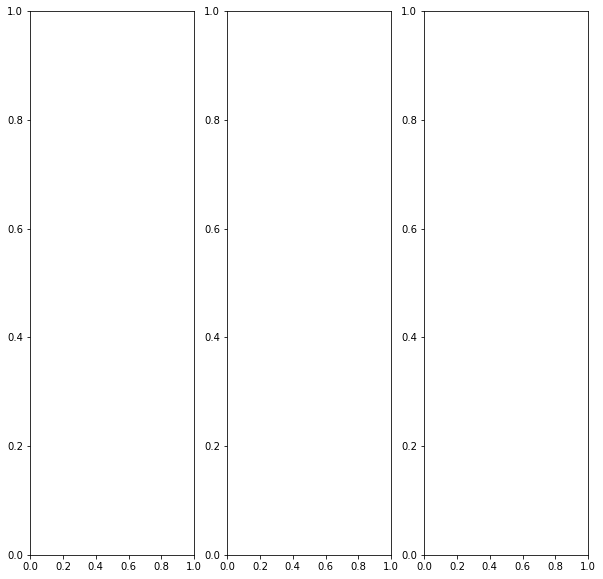

In [16]:
# First let's create our plotting area
fig = plt.figure(figsize=(10.0, 10.0))

# and add panels to plot in
axes1 = fig.add_subplot(1, 3, 1)
axes2 = fig.add_subplot(1, 3, 2)
axes3 = fig.add_subplot(1, 3, 3)

`plt.figure` sets up a space for us to plot while `fig.add_suplot` adds panels to the figure `fig`.  
In `fig.add_subplot` the three numbers tell matplotlib (the number of rows, the number of columns, and the position of the axes we are making in each line of code.  

Blank axes are great and all but why dont we add some data?

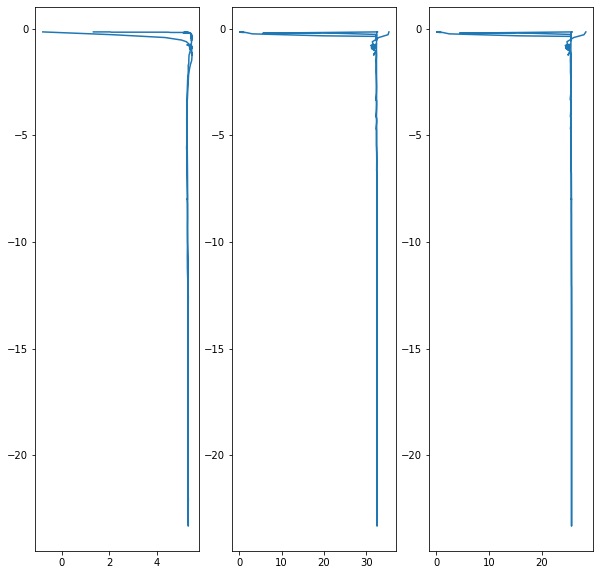

In [17]:
# First let's create our plotting area
fig = plt.figure(figsize=(10.0, 10.0))

# and add panels to plot in
axes1 = fig.add_subplot(1, 3, 1)
axes2 = fig.add_subplot(1, 3, 2)
axes3 = fig.add_subplot(1, 3, 3)

axes1.plot(data['Temperature [°C]'],data['Depth [m]'])

axes2.plot(data['Salinity [PSU]'],data['Depth [m]'])

axes3.plot(data['Density [kg/m3]'],data['Depth [m]'])

Sweet now we have lines! It looks like this data was collected as the CTD was dunked and as it was pulled back up so we cover every depth twice. I think I may have forgotten the Cardinal Rule of making a graph. There is no title or axes labels or units!

Text(0.5, 0.98, 'CTD cast from 2/8/2021 off NJ')

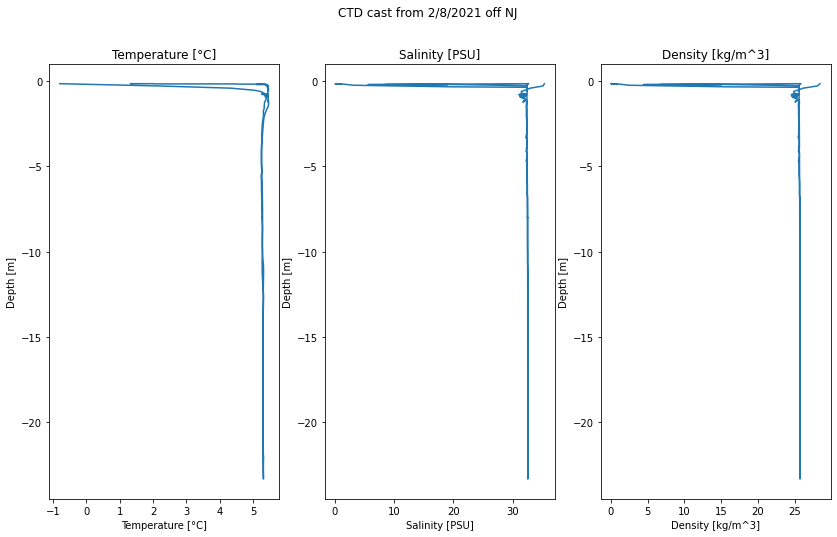

In [18]:
# First let's create our plotting area
fig = plt.figure(figsize=(14.0, 8.0))

# and add panels to plot in
axes1 = fig.add_subplot(1, 3, 1)
axes2 = fig.add_subplot(1, 3, 2)
axes3 = fig.add_subplot(1, 3, 3)

axes1.plot(data['Temperature [°C]'],data['Depth [m]'])
axes2.plot(data['Salinity [PSU]'],data['Depth [m]'])
axes3.plot(data['Density [kg/m3]'],data['Depth [m]'])

axes1.set_ylabel('Depth [m]')
axes1.set_xlabel('Temperature [°C]')
axes1.set_title('Temperature [°C]')

axes2.set_ylabel('Depth [m]')
axes2.set_xlabel('Salinity [PSU]')
axes2.set_title('Salinity [PSU]')

axes3.set_ylabel('Depth [m]')
axes3.set_xlabel('Density [kg/m^3]')
axes3.set_title('Density [kg/m^3]')

plt.suptitle('CTD cast from 2/8/2021 off NJ')

Something still looks _wonky_ with the upper couple meters of data. Why don't we zoom in on the right side of each plot by setting our x axis limits using `axes1.set_xlim` and repeating for each axes

Text(0.5, 0.98, 'CTD cast from 2/8/2021 off NJ')

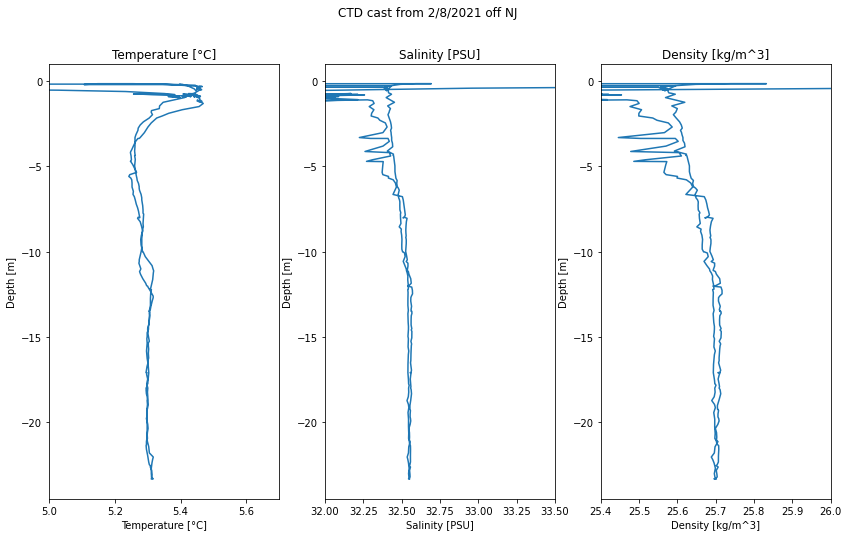

In [19]:
# First let's create our plotting area
fig = plt.figure(figsize=(14.0, 8.0))

# and add panels to plot in
axes1 = fig.add_subplot(1, 3, 1)
axes2 = fig.add_subplot(1, 3, 2)
axes3 = fig.add_subplot(1, 3, 3)

axes1.plot(data['Temperature [°C]'],data['Depth [m]'])
axes2.plot(data['Salinity [PSU]'],data['Depth [m]'])
axes3.plot(data['Density [kg/m3]'],data['Depth [m]'])

axes1.set_ylabel('Depth [m]')
axes1.set_xlabel('Temperature [°C]')
axes1.set_title('Temperature [°C]')
axes1.set_xlim([5,5.7])

axes2.set_ylabel('Depth [m]')
axes2.set_xlabel('Salinity [PSU]')
axes2.set_title('Salinity [PSU]')
axes2.set_xlim([32,33.5])

axes3.set_ylabel('Depth [m]')
axes3.set_xlabel('Density [kg/m^3]')
axes3.set_title('Density [kg/m^3]')
axes3.set_xlim([25.4,26])

plt.suptitle('CTD cast from 2/8/2021 off NJ')

Now we can see some of the variability in these properties over depth! There is a slightly warmer surface layer, salinity increases with depth, and density increases with depth so the water column seems stable!  

# Plotting T-S diagram
Making a scatter plot relating Salinity and Temperature can inform us about different water masses encountered in the data. We can plot three variables on a scatter plot by assigning one variable to the x-axis, one to the y-axis, and one to the color of the scattered datapoints.

Text(0, 0.5, 'Temperature [°C]')

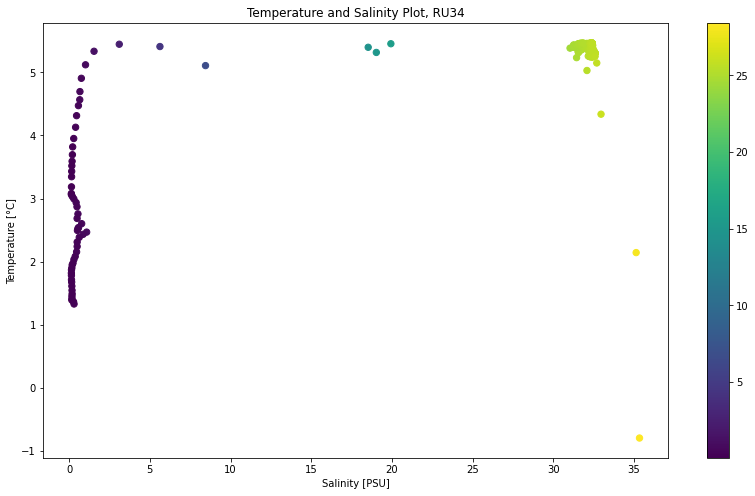

In [20]:
fig = plt.figure(figsize=(14.0, 8.0))

plt.scatter(data['Salinity [PSU]'], data['Temperature [°C]'], s=40, c=data['Density [kg/m3]'])
plt.colorbar()

plt.title('Temperature and Salinity Plot, RU34')
plt.xlabel('Salinity [PSU]')
plt.ylabel('Temperature [°C]')

Looks like we've got some fresh, cold water and some warmer, saliter water. Let's zoom in on the warmer saltier water to see if we can decipher any more detail in that blob. We're going to use `plt.xlim` and `plt.ylim` to bound our axes, and then `vmin` and `vmax` to bound our colorbar.

Text(0, 0.5, 'Temperature [°C]')

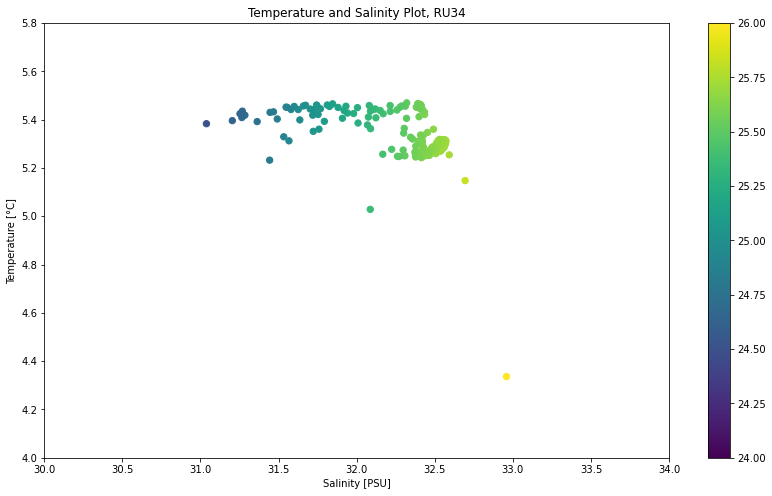

In [21]:
fig = plt.figure(figsize=(14.0, 8.0))
plt.scatter(data['Salinity [PSU]'], data['Temperature [°C]'], s=40, c=data['Density [kg/m3]'], vmin = 24, vmax = 26)
plt.colorbar()
plt.xlim([30, 34])
plt.ylim([4,5.8])

plt.title('Temperature and Salinity Plot, RU34')
plt.xlabel('Salinity [PSU]')
plt.ylabel('Temperature [°C]')

Nice job! Now you have plotted oceanographic data!  

Below, I want you to repeat these quality control, calculation, and plotting steps for another data file. I will load it in for you but you have to do the rest! Use these notes to help you out along the way!

# Now you do it!
Use the code below to load in a different CTD cast (this one is from August). <br>
(1) Remove the header and the data from before the instrument was in the water. <br>
(2) Calculate density and depth, then plot profiles for temperature, salinity, and density as we did above. <br>
(3) Plot a T-S diagram for this CTD cast. <br>
(4) How does this cast differ from the one above? How is it the similar? What are some potential reasons from these similarities / differences?

In [22]:
data2 = pd.read_csv('./2021_08_12_mara02_recovery.cnv',
                   skiprows=np.arange(0,124), # Lets us skip the big header at the top of the file
                   names=['Temperature [°C]', # gives names to each of the columns 
                          'Conductivity [S/m]',
                          'Pressure [db]'],
                   index_col=False,           # Forces pandas to not take the first column as an index
                   delimiter=' ',             # The data is separted into columns by spaces so we have to tell pandas that
                   skipinitialspace=True,     # This tells pandas that any number of spaces means its a new value
                  usecols=[0,1,2])            # Only pull out the 1st 2nd 3rd column of data

print(data2.keys())
print(data2)

Index(['Temperature [°C]', 'Conductivity [S/m]', 'Pressure [db]'], dtype='object')
     Temperature [°C]  Conductivity [S/m]  Pressure [db]
0             31.3058            0.002011         -0.342
1             31.1834            0.001863         -0.316
2             31.1021            0.001863         -0.289
3             31.0601            0.001813         -0.289
4             31.0181            0.001764         -0.289
..                ...                 ...            ...
394           24.9998            0.834771         -0.276
395           25.0094            0.601061         -0.289
396           25.0226            1.023001         -0.329
397           25.0359            0.462850         -0.316
398           25.0440            0.362431         -0.289

[399 rows x 3 columns]


In [23]:
dropind = np.where(data2['Conductivity [S/m]'] < 0)[0] # Find all the rows that have a negative Conductivity

data2.drop(index=dropind, inplace=True) # drop the rows indicated by drop ind
data2.reset_index(inplace=True, drop=True) # reset the index so the first value has index=0 and drop the old index.
print(data2)

     Temperature [°C]  Conductivity [S/m]  Pressure [db]
0             31.3058            0.002011         -0.342
1             31.1834            0.001863         -0.316
2             31.1021            0.001863         -0.289
3             31.0601            0.001813         -0.289
4             31.0181            0.001764         -0.289
..                ...                 ...            ...
394           24.9998            0.834771         -0.276
395           25.0094            0.601061         -0.289
396           25.0226            1.023001         -0.329
397           25.0359            0.462850         -0.316
398           25.0440            0.362431         -0.289

[399 rows x 3 columns]


In [24]:
PS = gsw.conversions.SP_from_C(data2['Conductivity [S/m]']*10, 
                               data2['Temperature [°C]'],
                               data2['Pressure [db]'])
depth = gsw.conversions.z_from_p(data2['Pressure [db]'], lat= 40) # I got the latitude from the header of the datafile
SA = gsw.conversions.SA_from_SP(PS,data2['Pressure [db]'].values, lon=-74,lat=39)
CT = gsw.conversions.CT_from_t(SA, data2['Temperature [°C]'].values, data2['Pressure [db]'].values)
rho = gsw.density.sigma0(SA,CT)
data2['Salinity [PSU]'] = PS
data2['Depth [m]']      = depth
data2['Density [kg/m3]']= rho

Text(0.5, 0.98, 'CTD cast from 8/122021 off NJ')

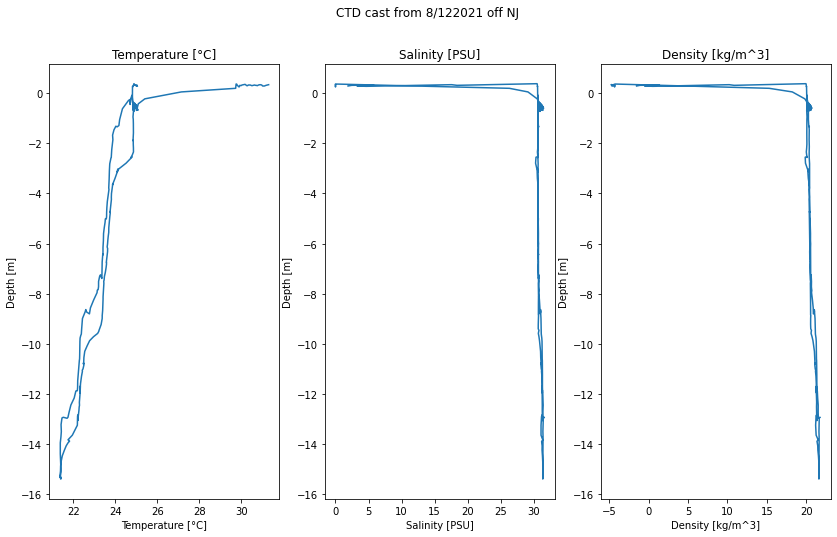

In [25]:
fig = plt.figure(figsize=(14.0, 8.0))

# and add panels to plot in
axes1 = fig.add_subplot(1, 3, 1)
axes2 = fig.add_subplot(1, 3, 2)
axes3 = fig.add_subplot(1, 3, 3)

axes1.plot(data2['Temperature [°C]'],data2['Depth [m]'])
axes2.plot(data2['Salinity [PSU]'],data2['Depth [m]'])
axes3.plot(data2['Density [kg/m3]'],data2['Depth [m]'])

axes1.set_ylabel('Depth [m]')
axes1.set_xlabel('Temperature [°C]')
axes1.set_title('Temperature [°C]')

axes2.set_ylabel('Depth [m]')
axes2.set_xlabel('Salinity [PSU]')
axes2.set_title('Salinity [PSU]')

axes3.set_ylabel('Depth [m]')
axes3.set_xlabel('Density [kg/m^3]')
axes3.set_title('Density [kg/m^3]')

plt.suptitle('CTD cast from 8/122021 off NJ')

Text(0.5, 0.98, 'CTD cast from 8/12/2021 off NJ')

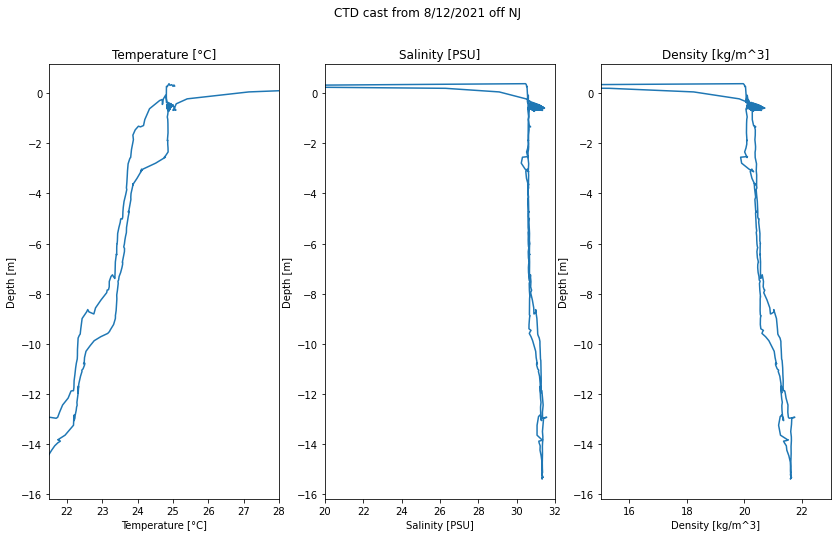

In [26]:
fig = plt.figure(figsize=(14.0, 8.0))

# and add panels to plot in
axes1 = fig.add_subplot(1, 3, 1)
axes2 = fig.add_subplot(1, 3, 2)
axes3 = fig.add_subplot(1, 3, 3)

axes1.plot(data2['Temperature [°C]'],data2['Depth [m]'])
axes2.plot(data2['Salinity [PSU]'],data2['Depth [m]'])
axes3.plot(data2['Density [kg/m3]'],data2['Depth [m]'])

axes1.set_ylabel('Depth [m]')
axes1.set_xlabel('Temperature [°C]')
axes1.set_title('Temperature [°C]')
axes1.set_xlim([21.5,28])

axes2.set_ylabel('Depth [m]')
axes2.set_xlabel('Salinity [PSU]')
axes2.set_title('Salinity [PSU]')
axes2.set_xlim([20,32])

axes3.set_ylabel('Depth [m]')
axes3.set_xlabel('Density [kg/m^3]')
axes3.set_title('Density [kg/m^3]')
axes3.set_xlim([15,23])

plt.suptitle('CTD cast from 8/12/2021 off NJ')

Text(0, 0.5, 'Temperature [°C]')

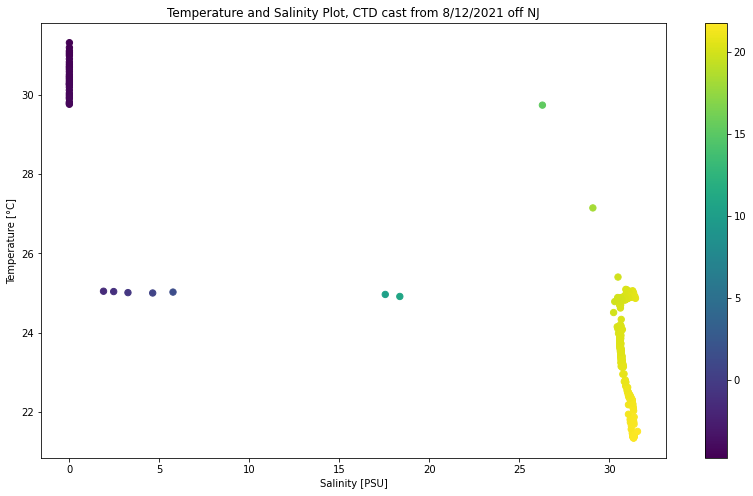

In [27]:
fig = plt.figure(figsize=(14.0, 8.0))

plt.scatter(data2['Salinity [PSU]'], data2['Temperature [°C]'], s=40, c=data2['Density [kg/m3]'])
# plt.scatter(data['Salinity [PSU]'], data['Temperature [°C]'], s=40, c=data['Depth [m]'])
plt.colorbar()

plt.title('Temperature and Salinity Plot, CTD cast from 8/12/2021 off NJ')
plt.xlabel('Salinity [PSU]')
plt.ylabel('Temperature [°C]')

Text(0, 0.5, 'Temperature [°C]')

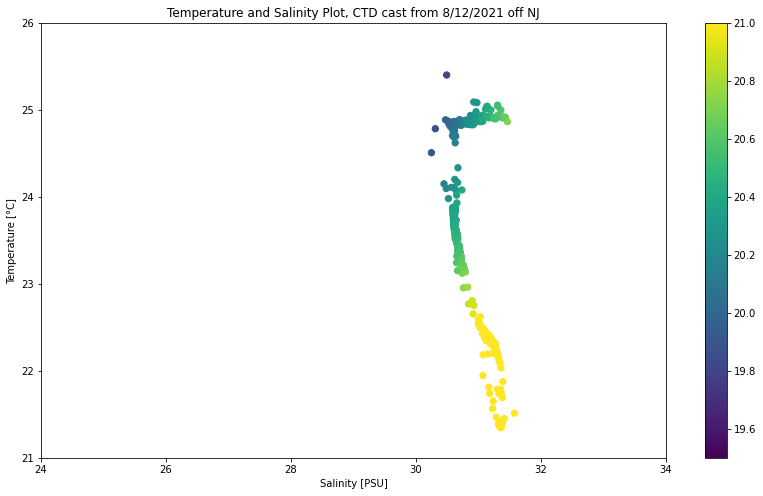

In [28]:
fig = plt.figure(figsize=(14.0, 8.0))
plt.scatter(data2['Salinity [PSU]'], data2['Temperature [°C]'], s=40, c=data2['Density [kg/m3]'], vmin = 19.5, vmax = 21)
plt.colorbar()
plt.xlim([24,34])
plt.ylim([21,26])

plt.title('Temperature and Salinity Plot, CTD cast from 8/12/2021 off NJ')
plt.xlabel('Salinity [PSU]')
plt.ylabel('Temperature [°C]')

In [29]:
def plot_TS_contours(T,S):
    mint=np.nanmin(T)
    maxt=np.nanmax(T)
    mins=np.nanmin(S)
    maxs=np.nanmax(S)
    tempL=np.linspace(mint-1,maxt+1,399)
    salL=np.linspace(mins-1,maxs+1,399)
    Tg, Sg = np.meshgrid(tempL,salL)
    sigma_theta = gsw.sigma0(Sg, Tg)+1000 # ignore effects of pressure on density
    cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),399)
    ind = np.argwhere(sigma_theta > 1015.7)
    st_short = sigma_theta[ind]
    cs = ax.contour(Sg, Tg, sigma_theta, colors='grey', zorder=1 ,levels=np.arange(st_short.min(), st_short.max()+1,1), vmin = 1014.7, vmax = 1022.7)
    levels = cs.levels
    cl= ax.clabel(cs,levels, fontsize=10,inline=True,fmt='%.1f')
    return cs

In [30]:
## index data2 vars to bounds so contour will bounded as well --> this would have been a lot easier in Xarray using the `.sel` function!!

dropind1 = np.where(data2['Salinity [PSU]'] < 24)[0]
data2.drop(index=dropind1, inplace=True)
data2.reset_index(inplace=True, drop=True)
dropind2 = np.where(data2['Salinity [PSU]'] > 34)[0]
data2.drop(index=dropind2, inplace=True)
data2.reset_index(inplace=True, drop=True)
dropind3 = np.where(data2['Temperature [°C]'] < 21)[0]
data2.drop(index=dropind3, inplace=True)
data2.reset_index(inplace=True, drop=True)
dropind4 = np.where(data2['Temperature [°C]'] > 26)[0]
data2.drop(index=dropind4, inplace=True)
data2.reset_index(inplace=True, drop=True)

data2

,Temperature [°C],Conductivity [S/m],Pressure [db],Salinity [PSU],Depth [m],Density [kg/m3]
0,25.4011,4.730321,0.227,30.491880,-0.225261,19.821501
1,25.0909,4.761406,0.426,30.926338,-0.422736,20.242257
2,25.0380,4.784795,0.598,31.132629,-0.593418,20.413659
3,24.9983,4.790230,0.678,31.199515,-0.672805,20.475996
4,24.9983,4.812110,0.691,31.359062,-0.685706,20.596310
...,...,...,...,...,...,...
355,24.8105,4.687065,0.095,30.575674,-0.094272,20.061581
356,24.8134,4.683445,-0.276,30.547416,0.273886,20.039387
357,24.8348,4.682992,-0.263,30.529650,0.260985,20.019628
358,24.8710,4.683896,-0.342,30.511824,0.339380,19.995410


In [31]:
# fig = plt.figure(figsize=(14.0, 8.0))
# plt.scatter(data2['Salinity [PSU]'], data2['Temperature [°C]'], s=40, c=data2['Density [kg/m3]'], vmin = 19.5, vmax = 21)
# plt.colorbar()
# plt.xlim([24,34])
# plt.ylim([21,26])

# plt.title('Temperature and Salinity Plot, CTD cast from 8/12/2021 off NJ')
# plt.xlabel('Salinity [PSU]')
# plt.ylabel('Temperature [°C]')
# cont = plot_TS_contours( data2['Temperature [°C]'],data2['Salinity [PSU]']) # you need to define an axis to plot contour ontop of scatter!!

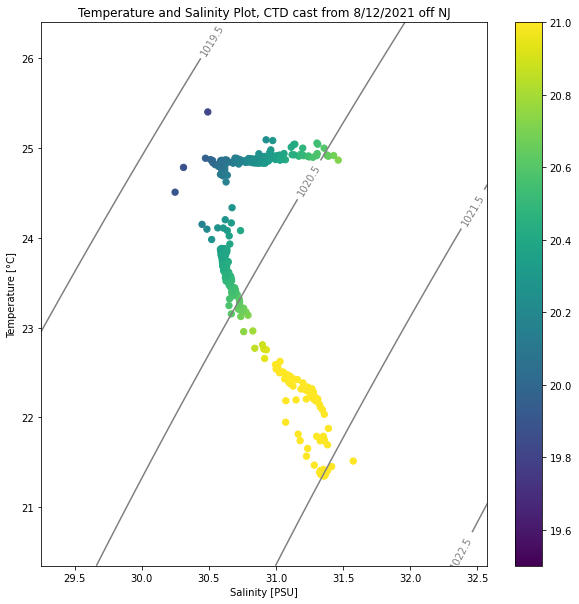

In [32]:
fig,ax=plt.subplots(figsize=(10,10))
sc = plt.scatter(data2['Salinity [PSU]'], data2['Temperature [°C]'], s=40, c=data2['Density [kg/m3]'], vmin = 19.5, vmax = 21)
cb = plt.colorbar()
# ax.set_xlim([24,34])
# ax.set_ylim([21,26])
# don't need set_xlim or set_ylim anymore because your data2 hold only the data you want to plot

plt.title('Temperature and Salinity Plot, CTD cast from 8/12/2021 off NJ')
plt.xlabel('Salinity [PSU]')
plt.ylabel('Temperature [°C]')
cont = plot_TS_contours( data2['Temperature [°C]'],data2['Salinity [PSU]'])